In [162]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import ocr_methods as ocr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from timeit import default_timer as timer

### Definição do Ponto Inicial

In [163]:
#exterior
#x = np.array([3., 2.])

#interior
x = np.array([0., 1.])

### Plot - Definição das curvas de nível e do range dos eixos

In [164]:
# x1range = np.linspace(-(x[0]+1), x[0] + 1)
# x2range = np.linspace(-(x[1]+1), x[1] + 1)

x1range = np.linspace(-10, 10)
x2range = np.linspace(-10, 10)

levellist = [0, 50, 200, 400, 800, 1600]
#levellist = 6


### Escolha dos métodos de OSR e OCR

In [165]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 2

if (metodo_ocr == 1):
    n_met_ocr = "Penalidade"
elif (metodo_ocr == 2):
    n_met_ocr = "Barreira"

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 4

if (metodo_osr == 1):
    n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [166]:
# numero maximo de iteracoes na OSR
maxiter = 1000

# tolerancia para convergencia do gradiente na OSR
tol_conv = 1E-6

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-8

# delta alpha do passo constante na OSR
line_step = 1E-2

#epsilon da maquina
eps = 1E-10

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 10
    beta = 0.1

#tolerancia OCR
tol = 1E-5

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [167]:
def f(x):
    return (x[0]-2)**4 + (x[0] - 2*x[1])**2

def grad_f(x):
    return np.array([4*(x[0]-2)**3 + 2*(x[0] - 2*x[1]), 2*(x[0] - 2*x[1])*(-2)])

def hess_f(x):
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([12*(x[0]-2)**2 + 2, -4.])
    hess[1,:] = np.array([-4., 8.])
    return hess

### Definição das restrições de desigualdade

In [168]:
def cl1(x):
    return x[0]**2 - x[1]

def grad_cl1(x):
    return np.array([2*x[0], -1.])

def hess_cl1(x):
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([2., 0.])
    hess[1,:] = np.array([0., 0])
    return hess

### Listas de Restrições e suas derivadas

In [169]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1]
grad_cl_list = [grad_cl1]
hess_cl_list = [hess_cl1]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

Newton-Raphson
1: x=[0.70794439 1.53149918], r=10, passos=4, conv=9.705779762661638
2: x=[0.82820091 1.10979842], r=1.0, passos=18, conv=2.359148921205389
3: x=[0.89886446 0.96384105], r=0.1, passos=3, conv=0.6415037512616691
4: x=[0.92935323 0.91630684], r=0.010000000000000002, passos=3, conv=0.19008003693070666
5: x=[0.9402783  0.90115305], r=0.0010000000000000002, passos=1000, conv=0.05872066571949257
Refazendo passo 6 com delta alpha = 0.001
6: x=[0.94388721 0.89635011], r=0.00010000000000000003, passos=1000, conv=0.01842618742067155
Refazendo passo 7 com delta alpha = 0.001
7: x=[0.94504487 0.89483026], r=1.0000000000000004e-05, passos=1000, conv=0.005812436944026422
Refazendo passo 8 com delta alpha = 0.001
Refazendo passo 8 com delta alpha = 0.0001
8: x=[0.94541264 0.89434954], r=1.0000000000000004e-06, passos=1000, conv=0.0018366026455991467
Refazendo passo 9 com delta alpha = 0.001
Refazendo passo 9 com delta alpha = 0.0001
9: x=[0.9455291  0.89419751], r=1.0000000000000005e-0

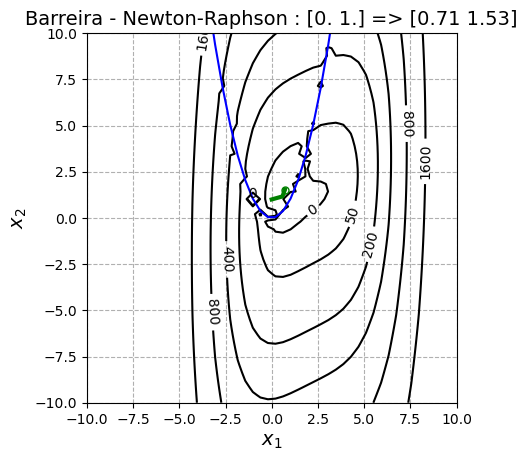

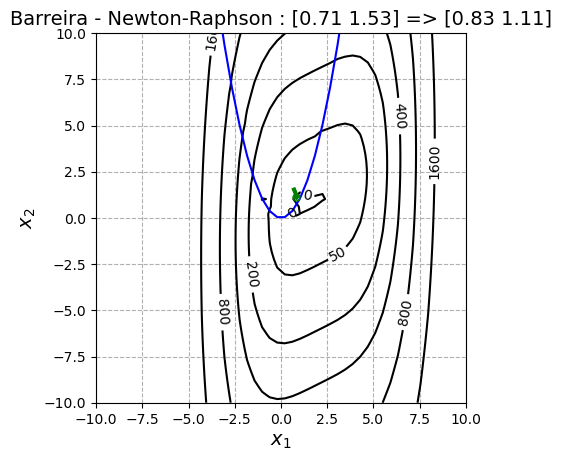

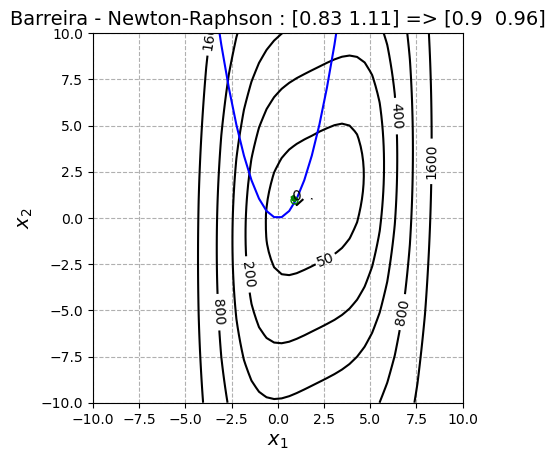

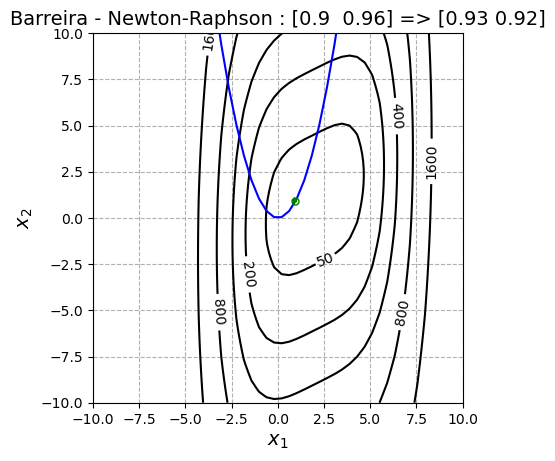

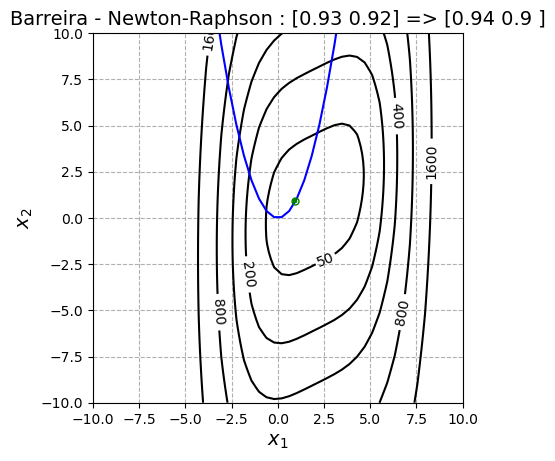

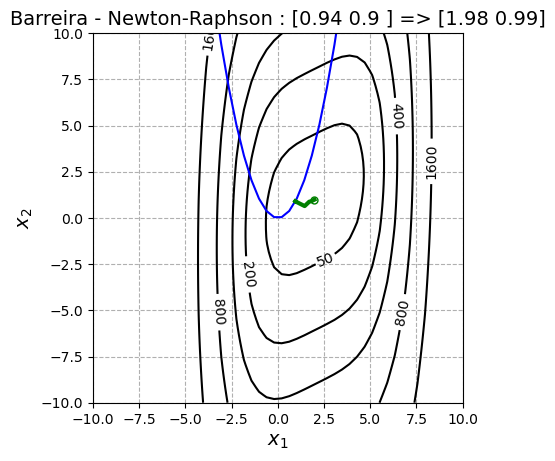

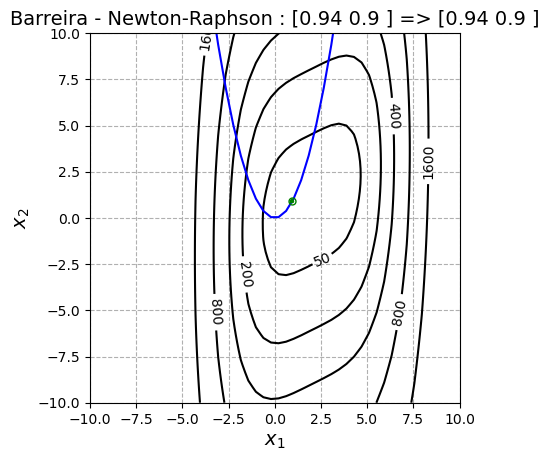

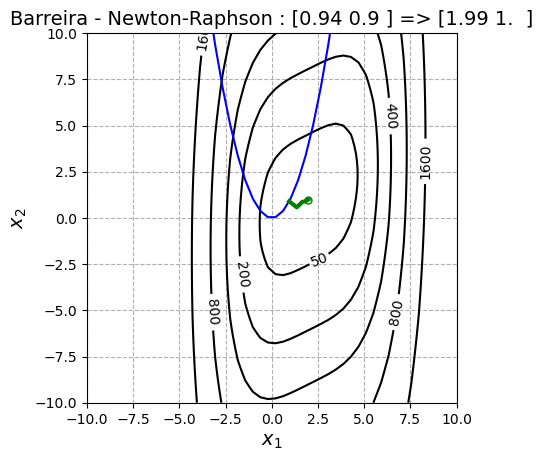

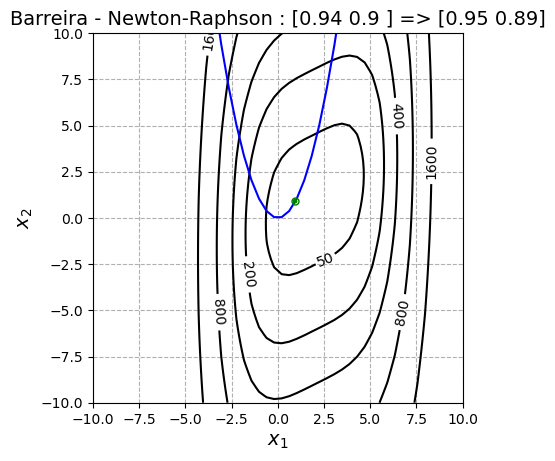

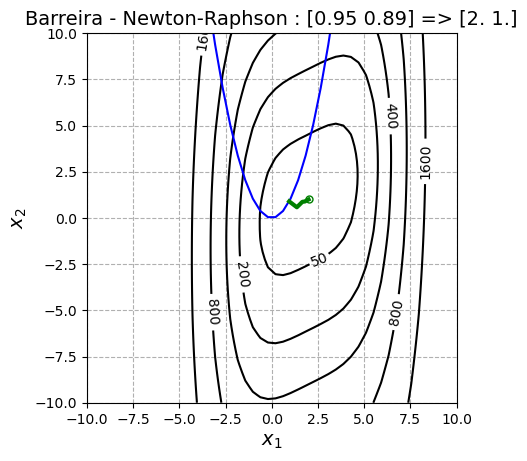

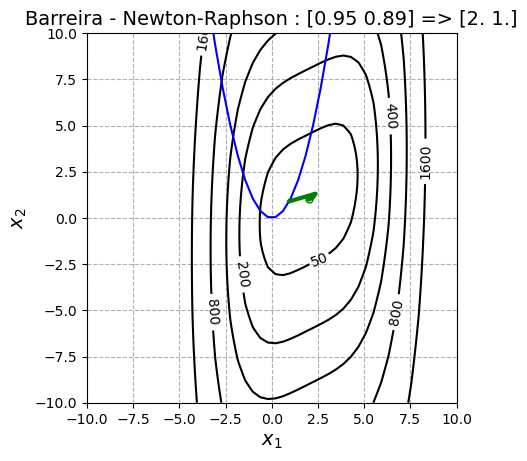

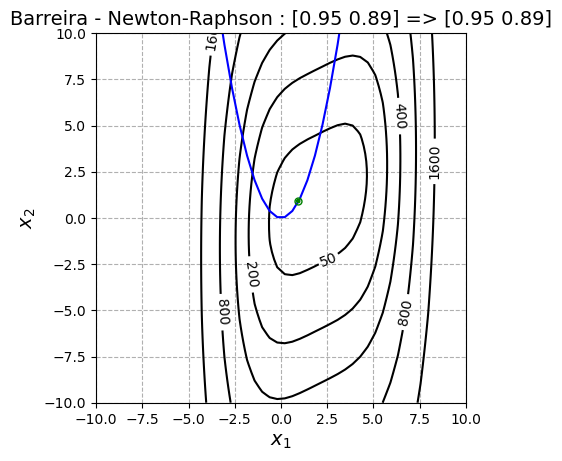

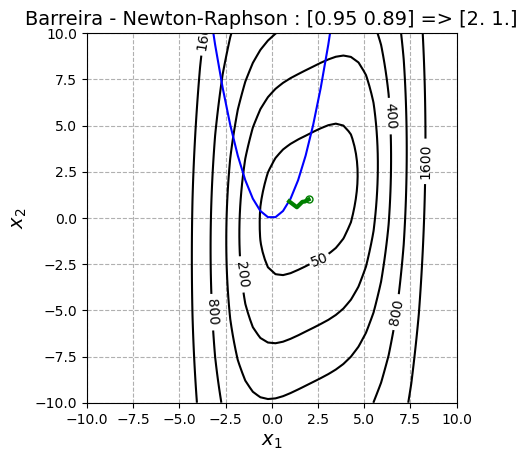

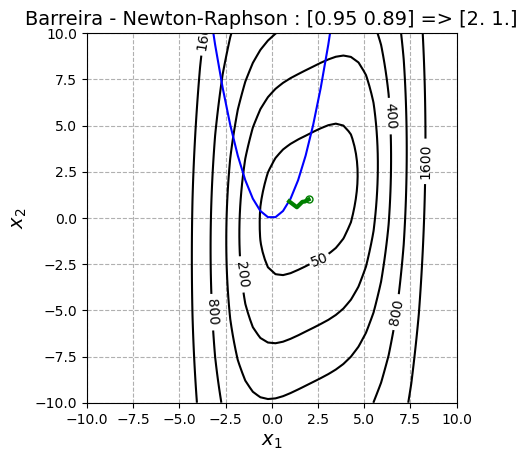

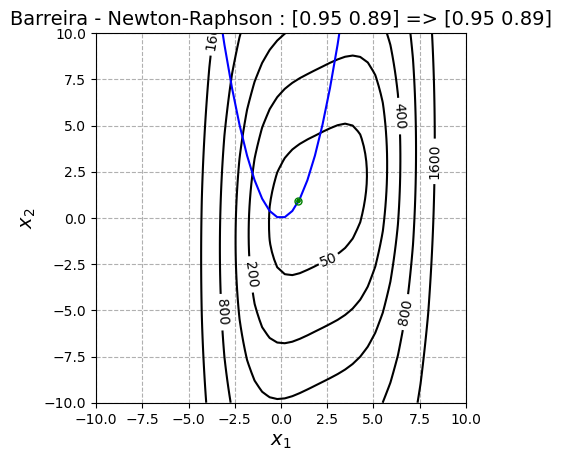

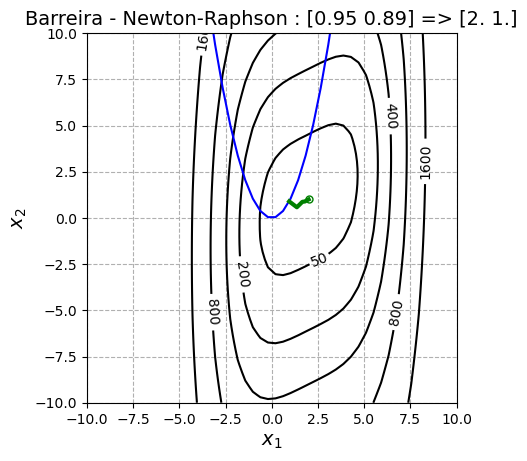

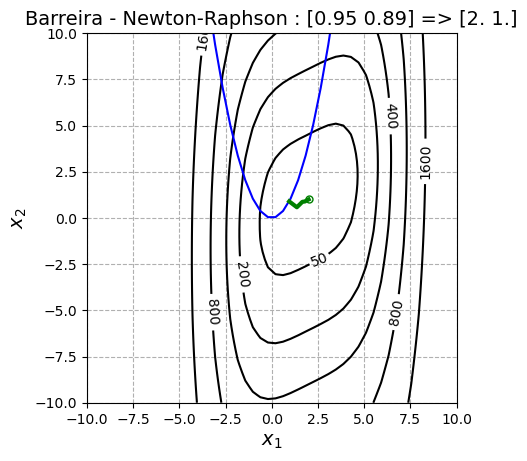

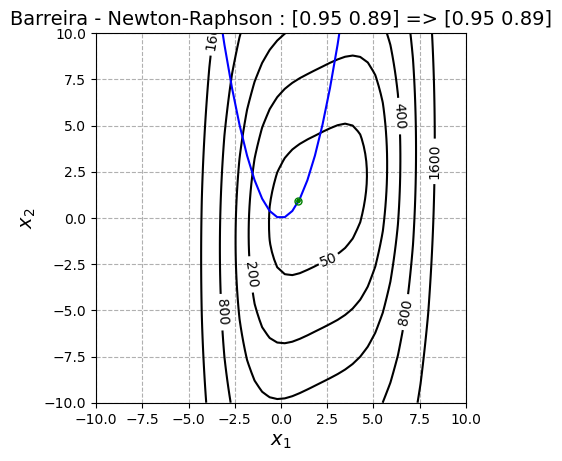

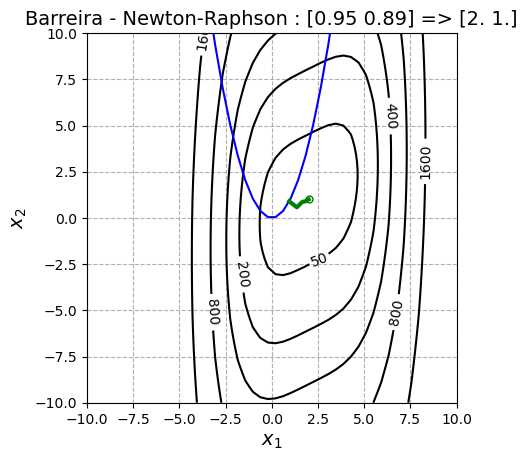

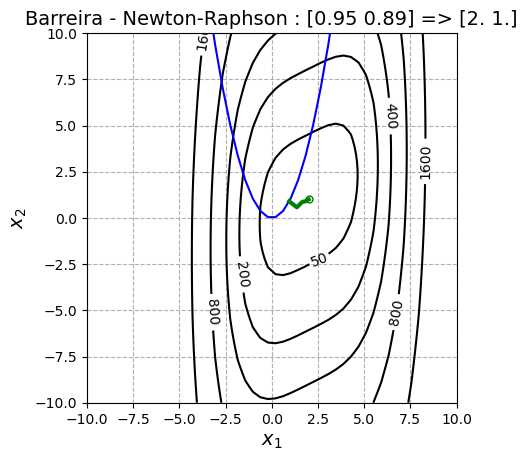

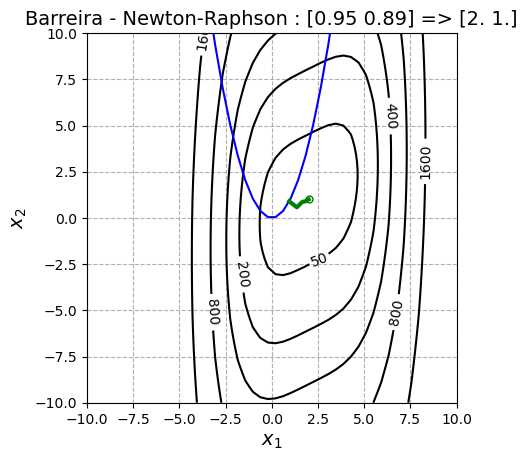

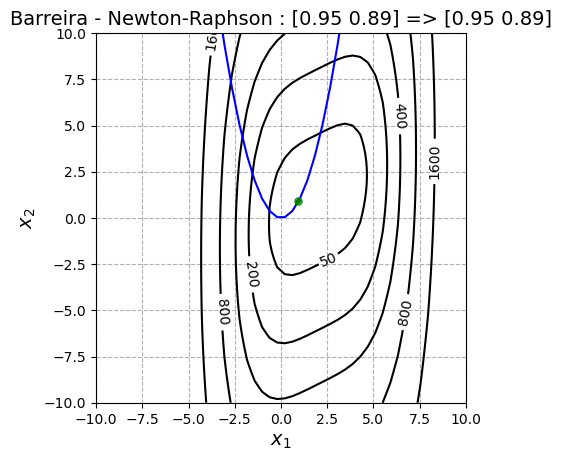

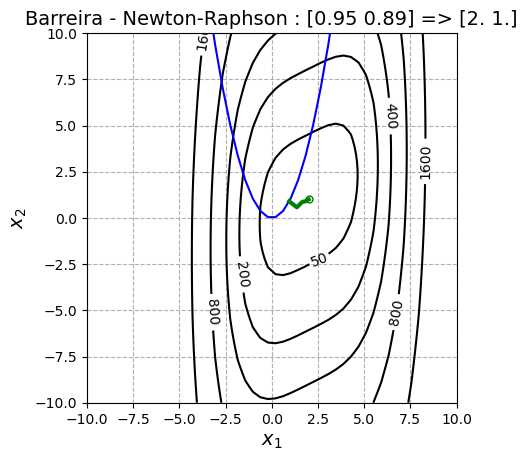

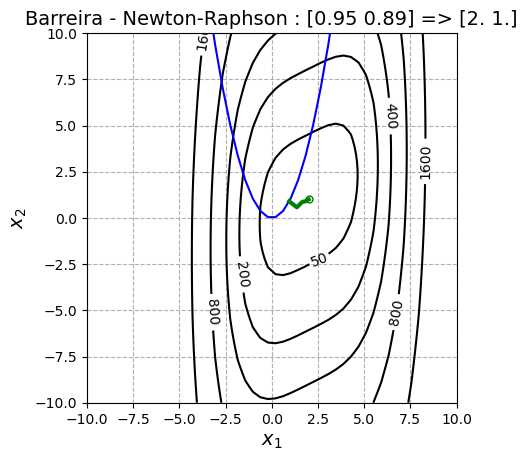

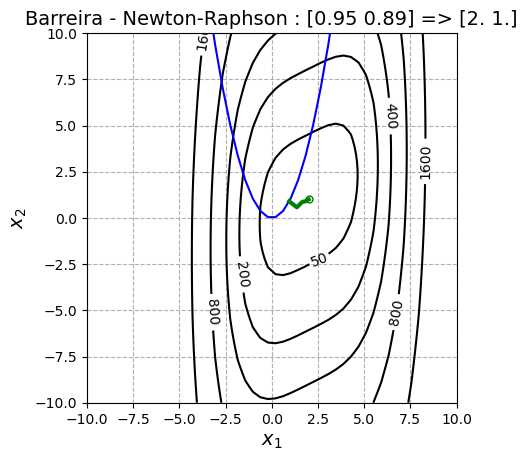

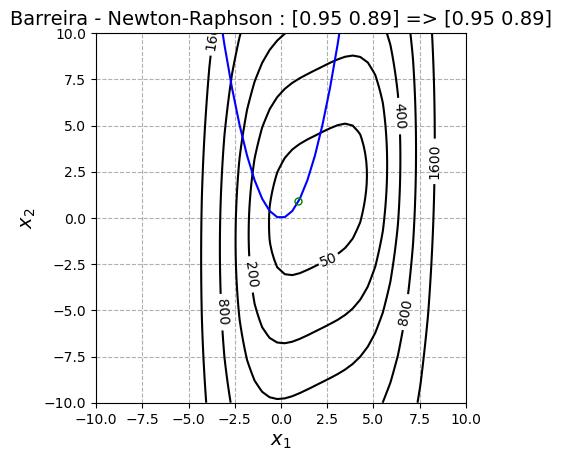

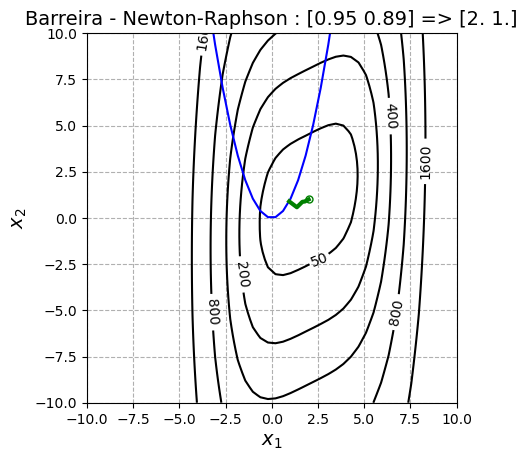

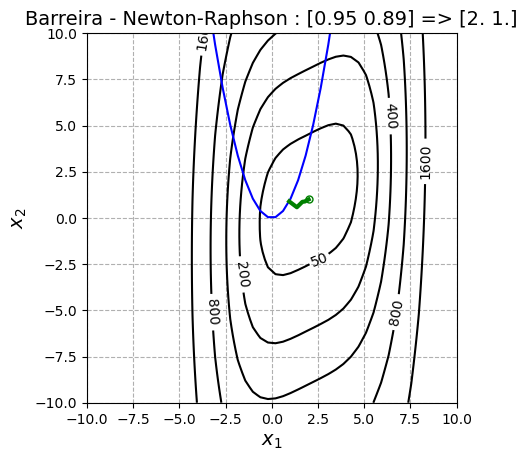

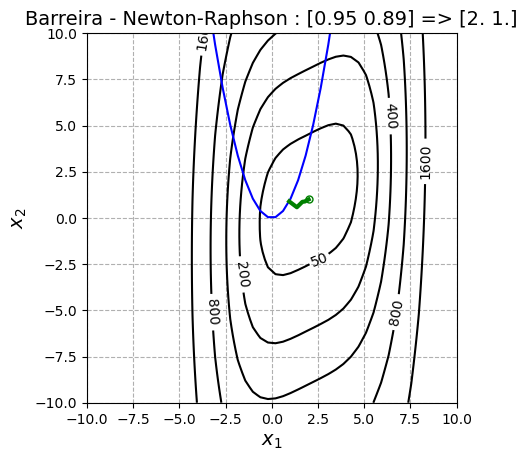

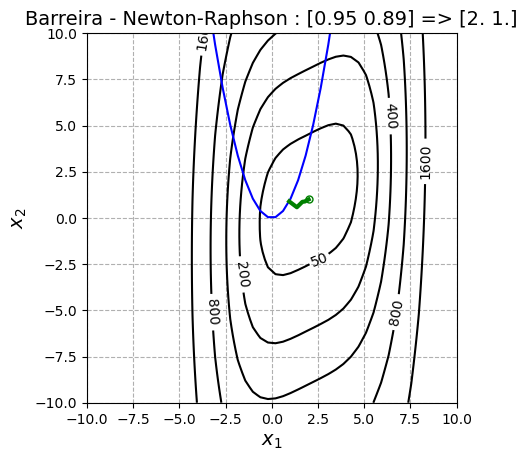

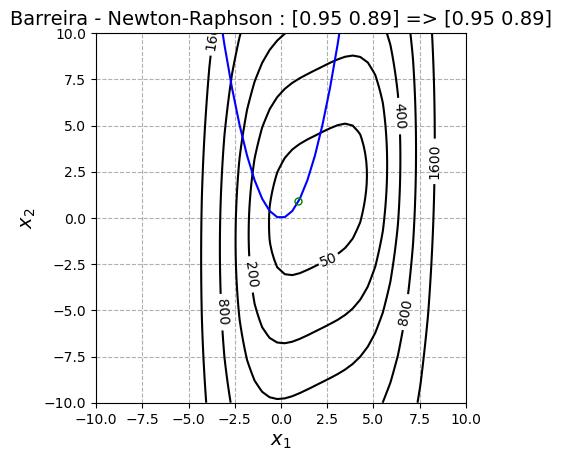

In [170]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listFigs = []

passos_OCR = 0
redo = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 1:
        r = beta*r
        # for i in np.arange(len(levellist)):
        #     levellist[i] = beta*levellist[i]
        if metodo_ocr == 1:
            cl_mont = []
            for cl in cl_list:
                if cl(x) > 0:
                    cl_mont.append(1)
                else:
                    cl_mont.append(0)
    listP_OSR, passos_OSR, flag_conv_OSR, tempoExec_OSR, fig = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr, x1range, x2range, levellist)
    
    if metodo_ocr == 2:
        redo = 0
        for cl in cl_list:
            if cl(listP_OSR[-1]) > 0:
                redo = 1
                break
    if (redo == 0):
        ctrl_num_osr[3] = line_step
        x = listP_OSR[-1]
        listP_OCR.append(x)
        listFigs.append(fig)
        if metodo_ocr == 1:
            parc = (1/2)*r*ocr.p_penal(x, params)
        elif metodo_ocr == 2:
            parc = r*ocr.b_bar(x, params)
        print(f'{passos_OCR}: x={x}, r={r}, passos={passos_OSR}, conv={parc}')
    elif (redo == 1):
        print(f'Refazendo passo {passos_OCR} com delta alpha = {0.1*ctrl_num_osr[3]}')
        passos_OCR = passos_OCR - 1
        r = r/beta
        ctrl_num_osr[3] = 0.1*ctrl_num_osr[3]
        
        
        
    #plt.close()
    

### Plots

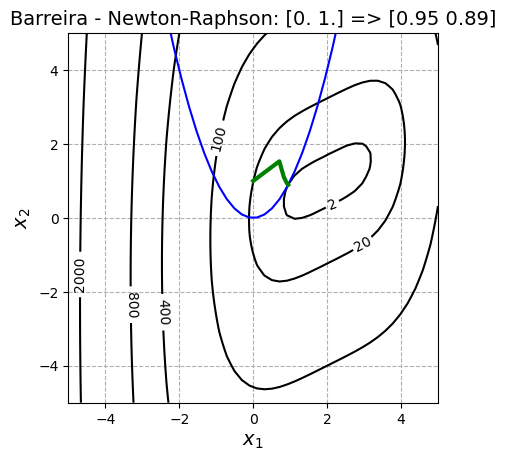

In [171]:
x1 = np.linspace(-5,5)
x2 = np.linspace(-5,5)
X1, X2 = np.meshgrid(x1, x2)

X3 = f([X1, X2])
    
figura, ax = plt.subplots()
        
niveis = ax.contour(X1, X2, X3, [0,2,20,100,400,800,2000,4000], colors='black')
ax.clabel(niveis, inline=1, fontsize=10)

for hk in hk_list:
    X3 = hk([X1,X2])
    plt.contour(X1, X2, X3, [0], colors='red')
    
for cl in cl_list:
    X3 = cl([X1,X2])
    plt.contour(X1, X2, X3, [0], colors='blue')
    
x = []
y = []
for P in listP_OCR:
    x.append(P[0])
    y.append(P[1])

ax.plot(x, y, color='g', linewidth='3')
ax.set_xlabel('$x_1$', fontsize='14')
ax.set_ylabel('$x_2$', fontsize='14')
ax.grid(linestyle='--')
ax = plt.gca()
ax.set_aspect(1)
titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ') 
ax.set_title(titulo, fontsize='14')
plt.show()



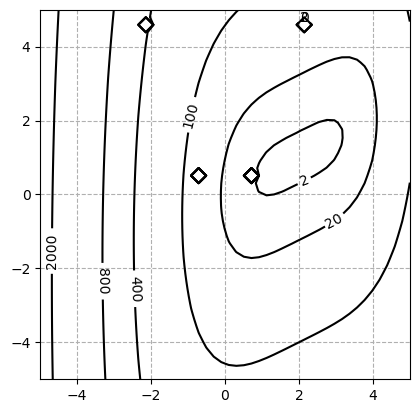

In [172]:
x1 = np.linspace(-5,5)
x2 = np.linspace(-5,5)
X1, X2 = np.meshgrid(x1, x2)

X3 = ocr.phi_bar([X1, X2], params, 0.00000001)

figura, ax = plt.subplots()
niveis = ax.contour(X1, X2, X3, [0,2,20,100,400,800,2000,4000], colors='black')
ax.clabel(niveis, inline=1, fontsize=10)


ax.grid(linestyle='--')
ax.set_aspect(1)

plt.show()
    